# **1) Import Libraries**

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
print(tf.__version__)


#**2) Mount driver**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# **3) Clone the tensorflow models & Install TensorFlow Object Detection API**





In [ ]:
# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .


# **4) Test the model builder**


In [ ]:
# testing the model builder
!python object_detection/builders/model_builder_tf2_test.py

# **5) Navigate to /mydrive/customTF2/data/ and Unzip the *images.zip* and *annotations.zip* files into the *data* folder**



In [ ]:
%cd /mydrive/customTF2/data/

# unzip the datasets and their contents so that they are now in /mydrive/customTF2/data/ folder
!unzip /mydrive/customTF2/images.zip -d .
!unzip /mydrive/customTF2/annotations.zip -d .

# **\*6)If .records files are not created. Create the CSV files and the "label_map.pbtxt" file**

Current working directory is /mydrive/customTF2/data/

Run xml_to_csv script below to create ***test_labels.csv*** and ***train_labels.csv***

This also creates the ***label_map.pbtxt*** file using the classes mentioned in the xml files. 

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')   

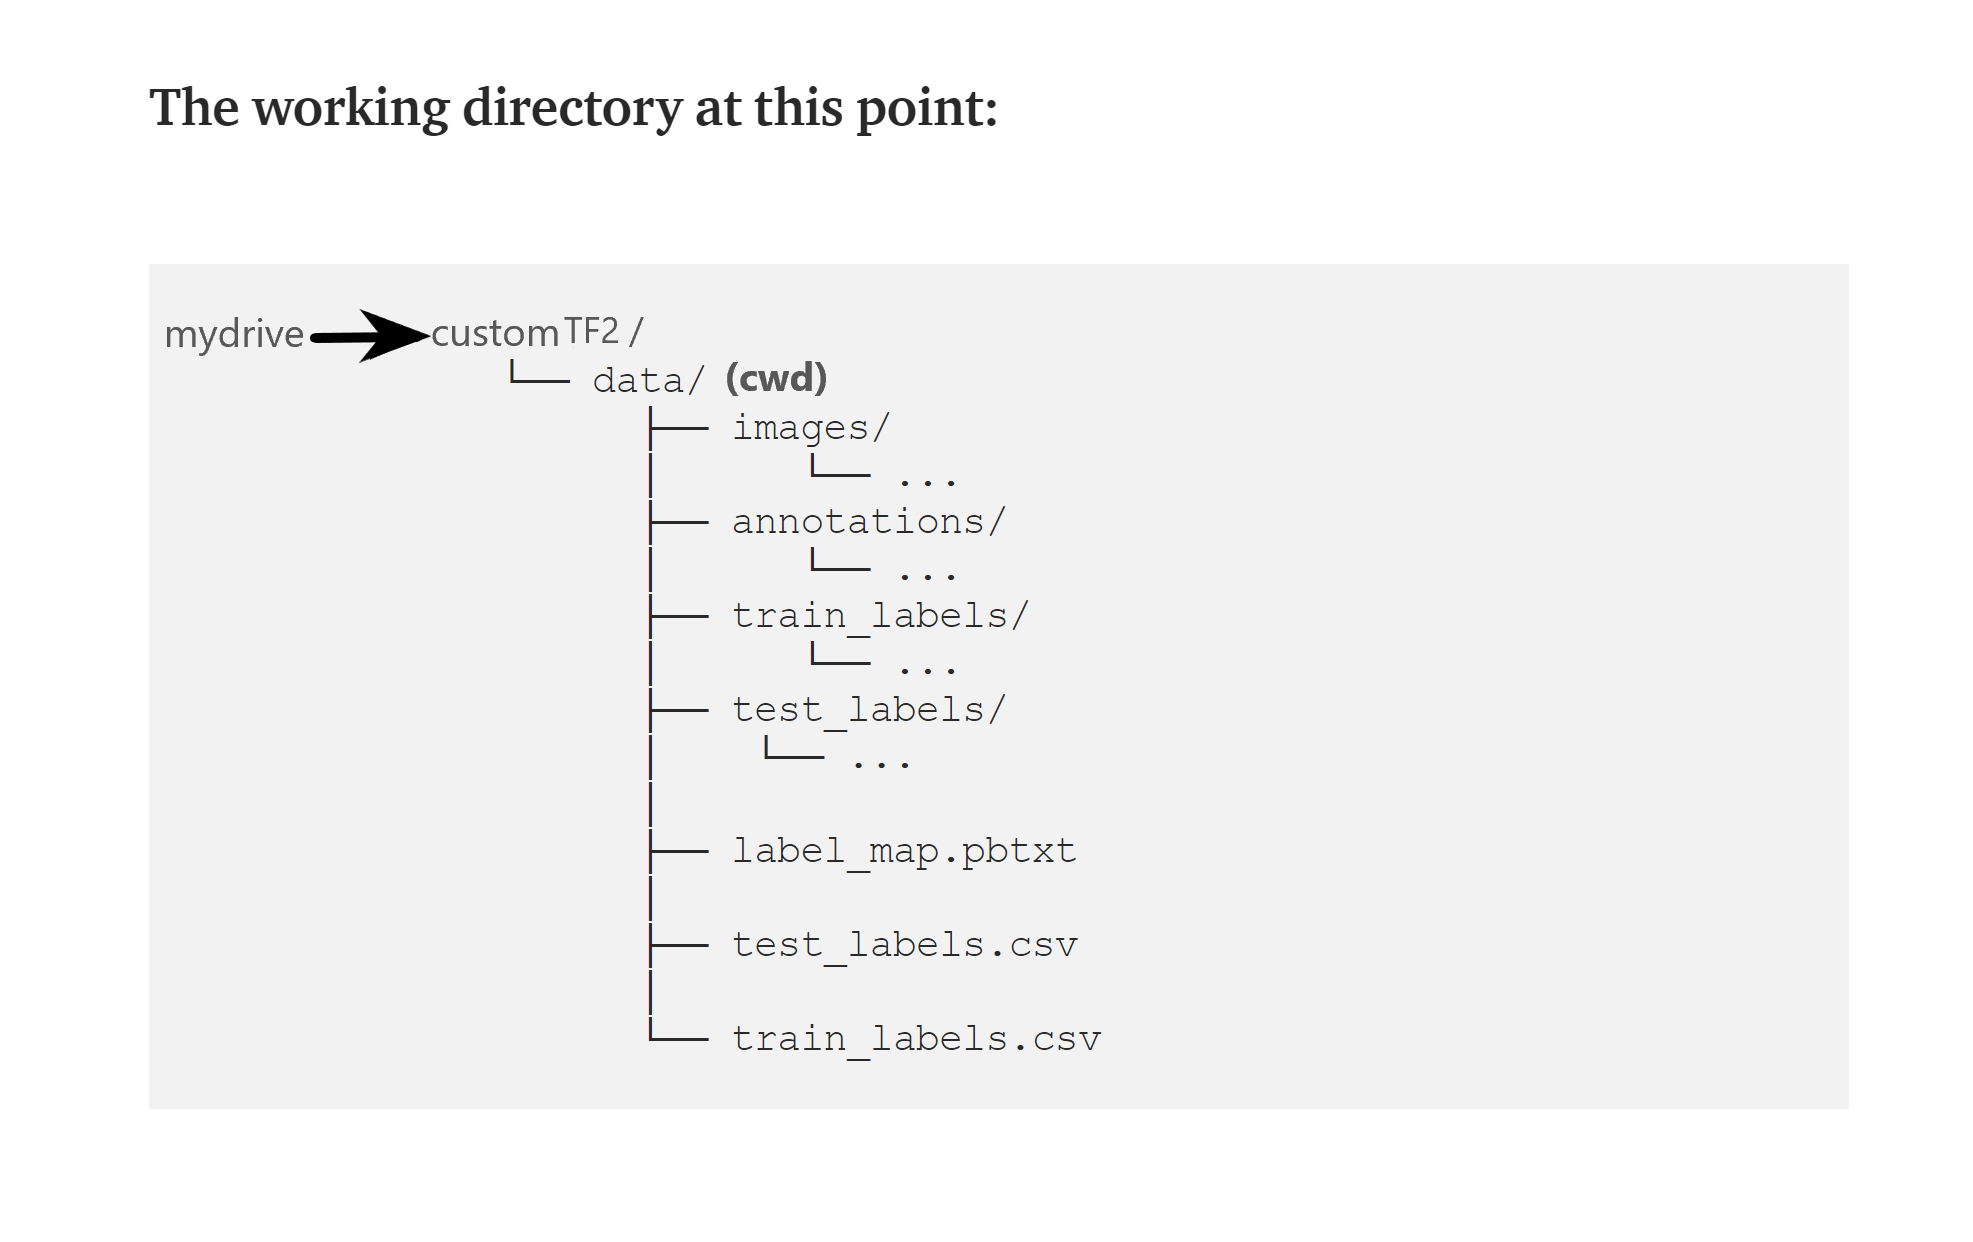

# **\*7)If .records files are not created. Create train.record & test.record files**

Current working directory is /mydrive/customTF2/data/

Run the *generate_tfrecord.py* script to create *train.record* and *test.record* files



In [ ]:
#Usage:  
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords

#For train.record
!python /mydrive/customTF2/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#For test.record
!python /mydrive/customTF2/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record


# **8) Download pre-trained model checkpoint** 

Current working directory is /mydrive/customTF2/data/

For Example:
Download **ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz** into the ***data*** folder & unzip it.

A list of detection checkpoints for tensorflow 2.x can be found [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).



In [ ]:
#Download the pre-trained model ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz into the data folder & unzip it.

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
!tar -xzvf faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz

# **9) Get the model pipeline config file, make changes to it and put it inside the *data* folder**

Current working directory is /mydrive/customTF2/data/

Download **ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config** from ***/content/models/research/object_detection/configs/tf2***. Make the required changes to it and upload it to the ***/mydrive/custom/data*** folder.


**You need to make the following changes:**
*   change ***num_classes*** to number of your classes.
*   change ***test.record*** path, ***train.record*** path & ***labelmap*** path to the paths where you have created these files (paths should be relative to your current working directory while training).
* change ***fine_tune_checkpoint*** to the path of the directory where the downloaded checkpoint from step 12 is. 
* change ***fine_tune_checkpoint_type*** with value **classification** or **detection** depending on the type..
* change ***batch_size*** to any multiple of 8 depending upon the capability of your GPU.
(eg:- 24,128,...,512).Mine is set to 64. 
* change ***num_steps*** to number of steps you want the detector to train. 







In [ ]:
#copy the edited config file from the configs/tf2 directory to the data/ folder in your drive

!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /mydrive/customTF2/data

# **10) Load Tensorboard**

In [ ]:
#load tensorboard

%load_ext tensorboard         
%tensorboard --logdir '/content/gdrive/MyDrive/customTF2bos/trainingfrcnn'

# **11) Train the model** 






## Navigate to the ***object_detection*** folder in colab vm


In [ ]:
%cd /content/models/research/object_detection

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

!pip install opencv-python-headless==4.5.2.52

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

## 11 (a) Training using model_main_tf2.py

Here **{PIPELINE_CONFIG_PATH}** points to the pipeline config and **{MODEL_DIR}** points to the directory in which training checkpoints and events will be written.

For best results, you should stop the training when the loss is less than 0.1 if possible, else train the model until the loss does not show any significant change for a while. The ideal loss should be below 0.05 (Try to get the loss as low as possible without overfitting the model. Don’t go too high on training steps to try and lower the loss if the model has already converged viz. if it does not reduce loss significantly any further and takes a while to go down. )

In [ ]:
# Run the command below from the content/models/research/object_detection directory
import time
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""
start_time = time.time(
!python model_main_tf2.py --pipeline_config_path=/content/gdrive/MyDrive/customTF2bos/data/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config --model_dir=/content/gdrive/MyDrive/customTF2bos/trainingfrcnn --alsologtostderr
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

## RETRAINING THE MODEL ( in case you get disconnected )




``` 
fine_tune_checkpoint: "/mydrive/customTF2/training/ckpt-X" (where ckpt-X is the latest checkpoint)

```


# **12) Test your trained model**

## Export inference graph

Current working directory is /content/models/research/object_detection

In [ ]:
##Export inference graph
!python exporter_main_v2.py --trained_checkpoint_dir=/content/gdrive/MyDrive/customTF2bos/trainingfrcnn --pipeline_config_path=/content/gdrive/MyDrive/customTF2bos/data/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config --output_directory /content/gdrive/MyDrive/customTF2bos/data/inf_frcnn

## Test your trained Object Detection model on images

Current working directory is /content/models/research/object_detection

In [ ]:
!unzip "/content/test_images.zip" -d "/content" #uploading test images

In [ ]:
!zip -r "/content/savedFrcnn.zip" "/content/gdrive/MyDrive/customTF2bos/data/inf_frcnn" #For save and download inference graph

In [ ]:
# Different font-type for labels text.(This step is optional)
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 20)/" visualization_utils.py
%cd ..

## This code for testing 1 image

In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/content/gdrive/MyDrive/customTF2ssd/data/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/customTF2bos/data/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

image_path = "/content/testforit/Gao_ship_vh_020161130030501002.jpg"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)
if(len(image_np.shape)<3):
      image_np = np.stack((image_np,)*3, axis=-1)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]
start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.3, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure()
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()

## This code for testing all test images and create test coordinates

In [ ]:
min_score_thresh=0.3
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline
image_path=""

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


relevant_path =  r'/content/testforit/'
relevant_path2 =  r'/content/res'
included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
file_names = [fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

cc=0
#start_time = time.time()
for image_path in file_names:

    cc=cc+1
    print('% ',(100*cc)/len(file_names))
    print(image_path)

    image_np = load_image_into_numpy_array(relevant_path+image_path)

    if(len(image_np.shape)<3):
      image_np = np.stack((image_np,)*3, axis=-1)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np,dtype=tf.uint8)
    #input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    #EKLEMEinput_tensor = input_tensor[:, :, :, :3]
    #input_tensor = np.expand_dims(image_np, 0)
    input_tensor = input_tensor[tf.newaxis, ...]
    start_time = time.time()

    detections = detect_fn(input_tensor)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Done! Took {} seconds'.format(elapsed_time))

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=20,
          min_score_thresh=.30,
          agnostic_mode=False)
    

        # This is the way I'm getting my coordinates
    boxes = detections['detection_boxes']
    # get all boxes from an array
    max_boxes_to_draw = boxes.shape[0]
    # get scores to get a threshold
    scores = detections['detection_scores']
    # this is set as a default but feel free to adjust it to your needs
    path = os.path.join(relevant_path2, image_path)
    # print(path)
    try:
      f = open(path[:-4] + '.txt', "w")
    except:
      print("An exception occurred")

    im_width = 256
    im_height = 256
    # print(im_width)

    # iterate over all objects found
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        #
        if scores is None or scores[i] > min_score_thresh:
            # boxes[i] is the box which will be drawn
            class_name = category_index[detections['detection_classes'][i]]['name']
            # print ("This box is gonna get used", boxes[i], detections['detection_classes'][i])
            xmin = round(boxes[i, 1] * im_width)
            xmax = round(boxes[i, 3] * im_height)
            ymin = round(boxes[i, 0] * im_width)
            ymax = round(boxes[i, 2] * im_height)
            score = round(detections['detection_scores'][i], 2)
            f.write(class_name + ' ' + str(score) + ' ' + str(xmin) + ' ' + str(ymin) + ' ' + str(xmax) + ' ' + str(
                ymax) + '\n')

    f.close()
    # iterate over all objects found
    #for i in range(min(max_boxes_to_draw, boxes.shape[0])):      
    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()
    time.sleep(1)

#end_time = time.time()
#elapsed_time = end_time - start_time
#print('Done! Took {} seconds'.format(elapsed_time))

In [ ]:
!zip -r "/content/test_resEffDet.zip" "/content/gdrive/MyDrive/test_res_effdet" #zip and upload test coordinates